## Data playground

In [1]:
# Import some common packages
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

### Testing transform on /r/Coronavirus

In [2]:
# Load data
data = pd.read_json('../data/relationship_advice-m100.json')
data['distinguished'] = data['distinguished'].fillna(value='none')

**Basic idea**: Provided that a significant portion of score distributions are _heavily_ skewed towards low values, it is reasonable to claim most low-scoring comments are insignificant, and may be categorized the same. However, instead of choosing a random criteria (e.g. everything below 100 is insignificant), we aim to choose a more empirically consistent criteria.

To do this, we observe the nature of our data below...

count    45482.000000
mean        46.276241
std        416.994173
min       -824.000000
25%          1.000000
50%          2.000000
75%          7.000000
max      27179.000000
Name: score, dtype: float64

more percentiles:
75.000%: 7.000
80.000%: 11.000
90.000%: 41.000
95.000%: 111.000
97.500%: 269.975
99.000%: 828.000
99.900%: 5859.393
99.990%: 15465.673
99.999%: 24597.044


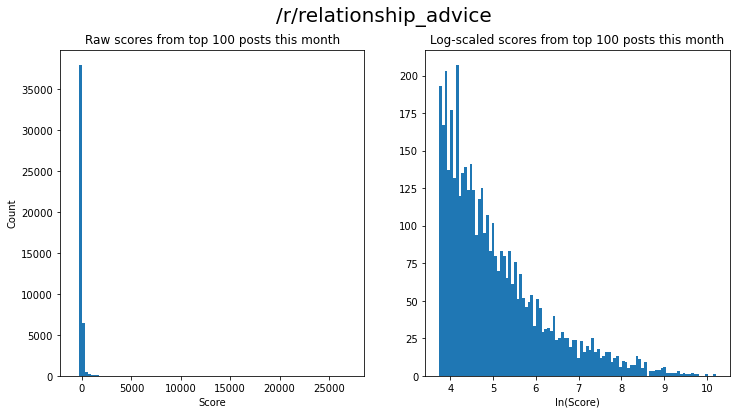

In [3]:
# basic info
print(data['score'].describe()); print()
print('more percentiles:')

percentiles = dict()
for i in (75, 80, 90, 95, 97.5, 99, 99.9, 99.99, 99.999):
    # store percentiles
    percentiles[i] = np.percentile(data['score'],i)
    print('{0:.3f}%: {1:.3f}'.format(i,percentiles[i]))

# take a look at score distribution...
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
ax1.hist(data['score'], 100)

# try stripping "insignificant" comments
data_stripped = list(filter(lambda x: x > percentiles[90], data['score']))
ax2.hist(np.log(data_stripped), 100)

plt.suptitle('/r/relationship_advice', fontsize=20)

ax1.set_title('Raw scores from top 100 posts this month')
ax2.set_title('Log-scaled scores from top 100 posts this month')

ax1.set(xlabel='Score', ylabel='Count')
ax2.set(xlabel='ln(Score)')

plt.show()

### Do all subreddits follow the same pattern?

As seen above, especially in the percentile breakdown, the vast majority of comments on _/r/Coronavirus_ have a very low score. Even without the breakdowns and graphs, one could just look at the quartiles, mean, and std. A good place to start to get a better understanding was truncating everything up to the 90th percentile (which could be a candidate "insignificant" categorical criterion) and performing a natural log-transform to see a better shape.

In [5]:
# subreddits to look at...
subreddits = [
#     'askreddit', 
    'conservative',
#     'funny', 
#     'gaming', 
    'news', 
#     'pics', 
    'politics', 
    'sandersforpresident', 
    'technology', 
    'worldnews'
]

# percentile cutoff
P = 90
data = list()

# get data for all
for sub in subreddits:
    # load
    try:
        d = pd.read_json('../data/{0}-m100.json'.format(sub))
    except:
        # something went wrong...
        continue
    d['distinguished'] = d['distinguished'].fillna(value='none')
    # strip
    d_stripped = list(
        filter(
            # to pass, must be above P percentile
            lambda x: x > np.percentile(d['score'], P),
            d['score']
        )
    )
    data.append(d_stripped)

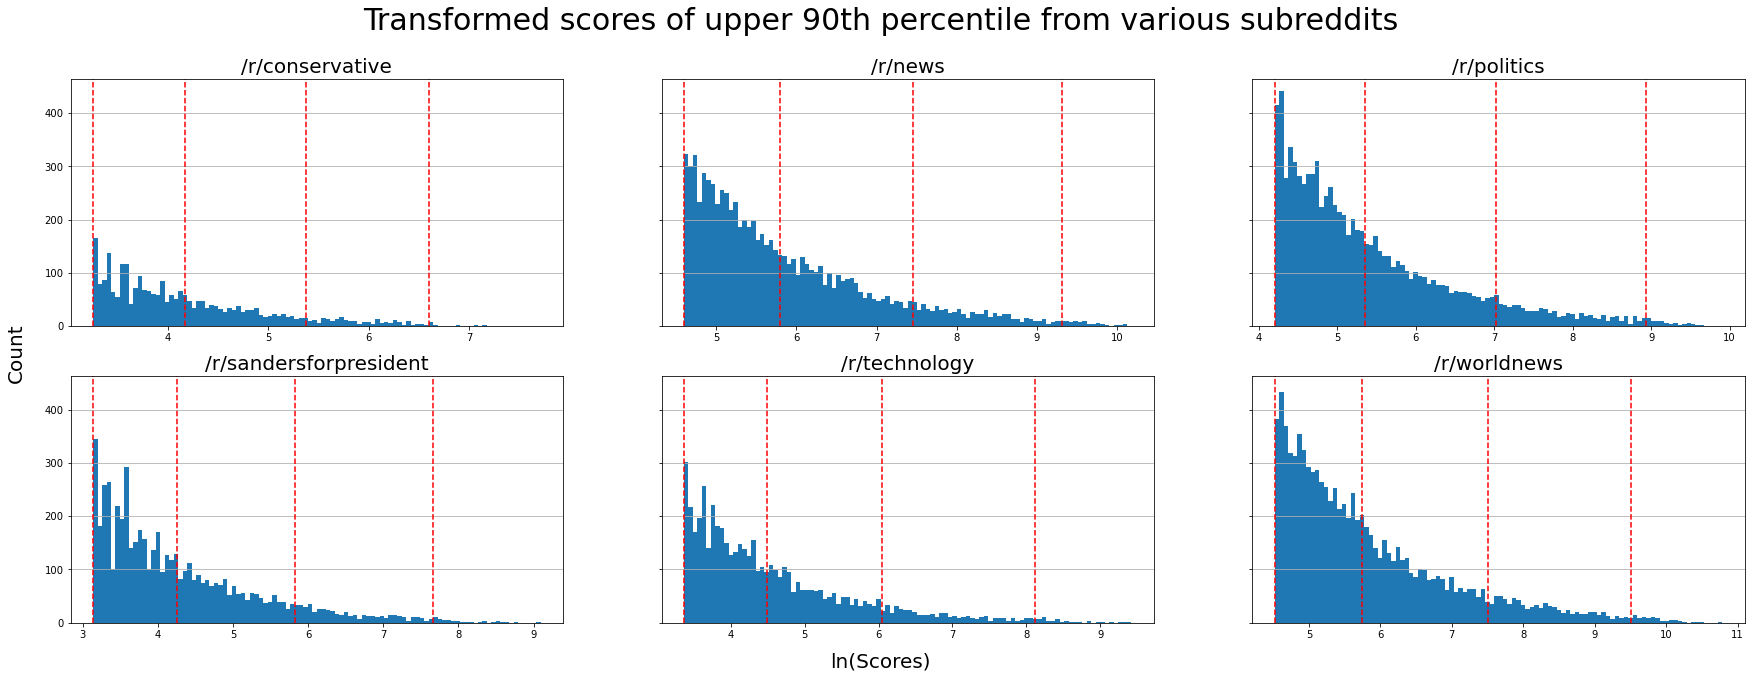

/r/conservative
0.0th percentile:	26.00 upvotes
60.0th percentile:	65.00 upvotes
90.0th percentile:	216.00 upvotes
99.0th percentile:	735.45 upvotes

/r/news
0.0th percentile:	99.00 upvotes
60.0th percentile:	329.00 upvotes
90.0th percentile:	1724.00 upvotes
99.0th percentile:	11128.47 upvotes

/r/politics
0.0th percentile:	67.00 upvotes
60.0th percentile:	212.00 upvotes
90.0th percentile:	1120.00 upvotes
99.0th percentile:	7558.35 upvotes

/r/sandersforpresident
0.0th percentile:	23.00 upvotes
60.0th percentile:	70.00 upvotes
90.0th percentile:	338.00 upvotes
99.0th percentile:	2136.20 upvotes

/r/technology
0.0th percentile:	29.00 upvotes
60.0th percentile:	88.80 upvotes
90.0th percentile:	421.70 upvotes
99.0th percentile:	3369.72 upvotes

/r/worldnews
0.0th percentile:	92.00 upvotes
60.0th percentile:	314.00 upvotes
90.0th percentile:	1832.80 upvotes
99.0th percentile:	13381.73 upvotes



In [26]:
# note that the 90th percentile is already omitted, as we truncated the data beforehand
categories = {
    'INSIGNIFICANT':  0.0,
    'SIGNIFICANT'  : 60.0,
    'POPULAR'      : 90.0,
    'VERY POPULAR' : 99.0
}

# plots (work with 10 subreddits)
fig, axs = plt.subplots(2, len(subreddits)//2, figsize=(30, 10), sharey=True)
i, bins = 0, 100
for r in range(axs.shape[0]):
    for c in range(axs.shape[1]):
        # natural log-transform
        d = np.log(data[i])
        axs[r,c].hist(d, bins)
        # set boundary lines
        for p in categories.values():
            axs[r,c].axvline(np.percentile(d, p), ls='--', color='r')
        axs[r,c].grid(axis='y')
        axs[r,c].set_title('/r/{0}'.format(subreddits[i]), fontsize=20)
        i += 1

fig.suptitle('Transformed scores of upper {0}th percentile from various subreddits'
             .format(P), fontsize=30)
fig.text(0.5, 0.07, 'ln(Scores)', ha='center', va='center', fontsize=20)
fig.text(0.1, 0.5, 'Count', ha='center', va='center', rotation='vertical', fontsize=20)
plt.show()

# show raw score boundaries (undo transformation)
for i in range(len(data)):
    print('/r/{0}'.format(subreddits[i]))
    for c in categories.values():
        print('{0}th percentile:\t{1:.2f} upvotes'.format(
            # get score of transformed percentile, undo transform
            c, np.exp(np.percentile(np.log(data[i]), c))
        ))
    print()


As shown above, it can be seen each subreddit can have its own _unique_ score distribution. This illustrates that for different models, it is ideal to have dynamic criteria for categorization of comment significance, provided that every subreddit exhibits its own distribution. It should be noted that the percentiles above are relative to the top 10 percent of scores + log-transform... meaning that the 0th percentile corresponds to the 90th percentile in the raw set, and 90th percentile corresponds to the 90th percentile of the ln(top 10 percent of scores).

In [ ]:
# TODO: autocategorize function